# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

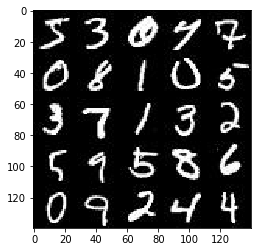

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

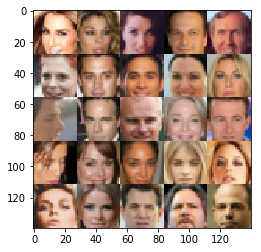

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/yann/miniconda2/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    z_data = tf.placeholder(tf.float32, [None, z_dim], name='z_dim') # 命名为 z_dim??
    learning_rate = tf.placeholder(tf.float32, None)

    return (real_input_images, z_data, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
#     n_units = 128 * 2
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, 64, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        h1 = tf.layers.batch_normalization(h1, training=True)
        h1 = tf.maximum(alpha * h1, h1)
        h1 = tf.layers.dropout(h1, 0.8)
        
        h2 = tf.layers.conv2d(h1, 128, 4, strides=2, padding="same")
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        h2 = tf.layers.dropout(h2, 0.8)
        
        h3 = tf.layers.conv2d(h2, 256, 4, strides=2, padding="same")
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        h3 = tf.layers.dropout(h3, 0.8)
        
        h3 = tf.reshape(h3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(h3, 1)
        out = tf.sigmoid(logits)
        
#         images = tf.contrib.layers.flatten(images)
#         # Hidden layer
#         h1 = tf.layers.dense(images, n_units, activation=None)
#         # Leaky ReLU
#         h1 = tf.maximum(alpha * h1, h1)
#         logits = tf.layers.dense(h1, 1, activation=None)
#         out = tf.sigmoid(logits)

    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
#     n_units = 128 * 2
    alpha = 0.2
    with tf.variable_scope('generator', reuse=reuse):
        z = tf.layers.dense(z, 4 * 4 * 512)
        
        h1 = tf.reshape(z, (-1, 4, 4, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d_transpose(h1, 256, 4, strides=1, padding="valid")
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d_transpose(h2, 128, 4, strides=2, padding="same")
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 4, strides=2, padding="same")
        out = tf.tanh(logits)
        
#         # Hidden layer
#         z = tf.contrib.layers.flatten(z)
#         h1 = tf.layers.dense(z, n_units, activation=None)
#         # Leaky ReLU
#         h1 = tf.maximum(alpha * h1, h1)
        
#         # Logits and tanh output
#         logits = tf.layers.dense(h1, 28 * 28 * out_channel_dim)
#         out = tf.tanh(logits)
#         out = tf.reshape(out, [-1, 28, 28, out_channel_dim])
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
#     print(input_real)
#     print(input_z)
    
    smooth = 0.1
    _, d_logits_real = discriminator(input_real, reuse=False)
    fake = generator(input_z, out_channel_dim, is_train=True)
    d_logits_fake = discriminator(fake, reuse=True)

    # Calculate losses
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step = step + 1
                
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, lr:learning_rate})
                
                if step % 100 == 0:
                    train_loss_d = d_loss.eval({inputs_z:batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z:batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(train_loss_d),
                         "Generator Loss: {:.4f}...".format(train_loss_g))

                if step % 200 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.2568... Generator Loss: 0.6319...
Epoch 1/2... Discriminator Loss: 1.6431... Generator Loss: 0.3413...


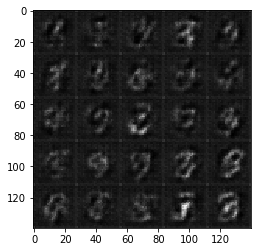

Epoch 1/2... Discriminator Loss: 1.7148... Generator Loss: 0.3395...
Epoch 1/2... Discriminator Loss: 1.6072... Generator Loss: 0.3579...


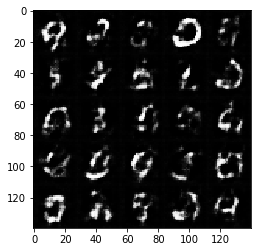

Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.4618...
Epoch 1/2... Discriminator Loss: 1.2963... Generator Loss: 0.7143...


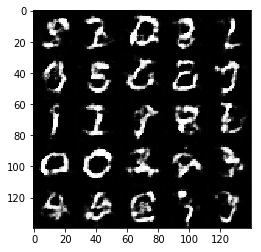

Epoch 1/2... Discriminator Loss: 1.1589... Generator Loss: 0.8210...
Epoch 1/2... Discriminator Loss: 1.7801... Generator Loss: 0.3106...


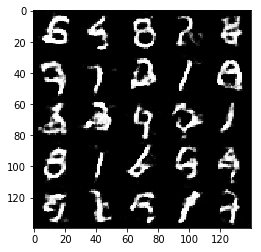

Epoch 1/2... Discriminator Loss: 1.2184... Generator Loss: 0.6186...
Epoch 1/2... Discriminator Loss: 1.3602... Generator Loss: 0.5134...


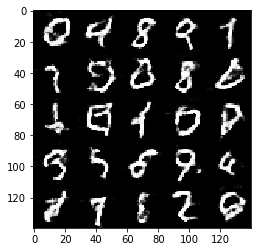

Epoch 1/2... Discriminator Loss: 1.2728... Generator Loss: 0.5833...
Epoch 1/2... Discriminator Loss: 1.1152... Generator Loss: 0.7487...


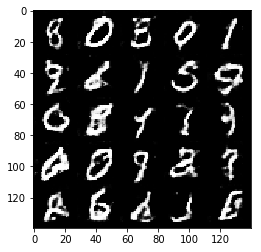

Epoch 1/2... Discriminator Loss: 1.1652... Generator Loss: 0.6260...
Epoch 1/2... Discriminator Loss: 1.4673... Generator Loss: 0.4430...


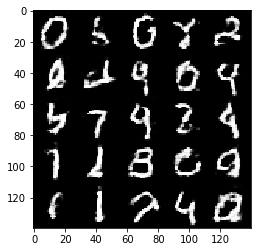

Epoch 1/2... Discriminator Loss: 1.3811... Generator Loss: 1.4073...
Epoch 1/2... Discriminator Loss: 1.3109... Generator Loss: 0.5205...


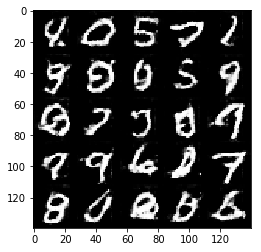

Epoch 1/2... Discriminator Loss: 1.1553... Generator Loss: 0.6801...
Epoch 1/2... Discriminator Loss: 1.0476... Generator Loss: 1.1594...


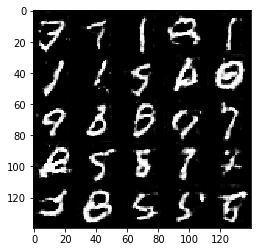

Epoch 2/2... Discriminator Loss: 0.9965... Generator Loss: 0.9487...
Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 0.8178...


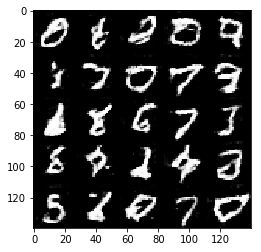

Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 0.7638...
Epoch 2/2... Discriminator Loss: 1.1977... Generator Loss: 0.6029...


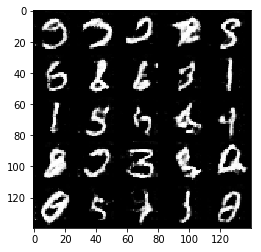

Epoch 2/2... Discriminator Loss: 1.0252... Generator Loss: 0.7983...
Epoch 2/2... Discriminator Loss: 0.9698... Generator Loss: 0.9267...


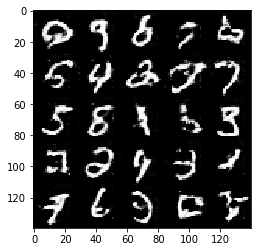

Epoch 2/2... Discriminator Loss: 1.0306... Generator Loss: 1.4280...
Epoch 2/2... Discriminator Loss: 1.2896... Generator Loss: 0.5734...


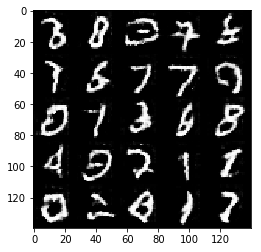

Epoch 2/2... Discriminator Loss: 1.6346... Generator Loss: 0.4037...
Epoch 2/2... Discriminator Loss: 2.1363... Generator Loss: 0.2550...


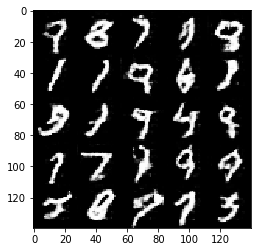

Epoch 2/2... Discriminator Loss: 2.2230... Generator Loss: 0.2606...
Epoch 2/2... Discriminator Loss: 0.9291... Generator Loss: 1.2328...


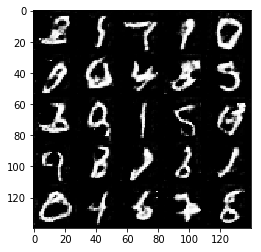

Epoch 2/2... Discriminator Loss: 1.1203... Generator Loss: 0.8064...
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 1.3970...


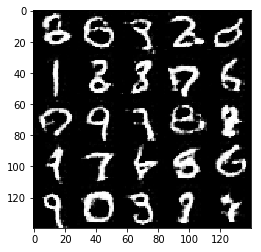

Epoch 2/2... Discriminator Loss: 1.0323... Generator Loss: 0.8094...
Epoch 2/2... Discriminator Loss: 0.9804... Generator Loss: 0.9094...


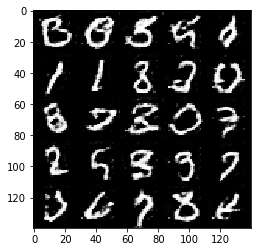

Epoch 2/2... Discriminator Loss: 0.9025... Generator Loss: 1.0679...
Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 0.7896...


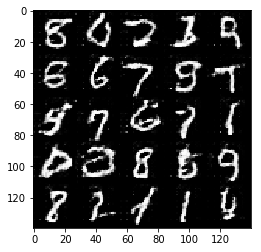

Epoch 2/2... Discriminator Loss: 1.0246... Generator Loss: 0.8399...


In [22]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.8891...
Epoch 1/1... Discriminator Loss: 1.7451... Generator Loss: 0.3328...


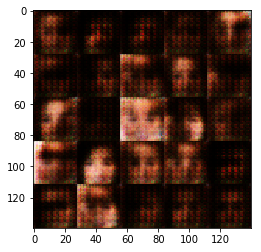

Epoch 1/1... Discriminator Loss: 1.6309... Generator Loss: 1.4722...
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 1.2810...


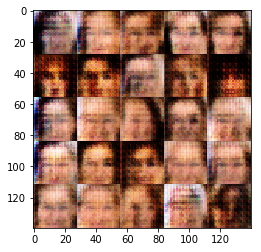

Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.5239...
Epoch 1/1... Discriminator Loss: 1.5808... Generator Loss: 0.9248...


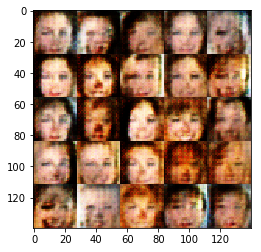

Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7023...
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.5192...


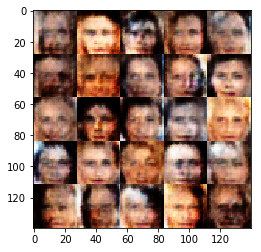

Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.9348...
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.4495...


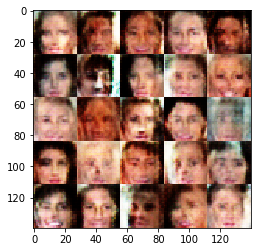

Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.6973...
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.8027...


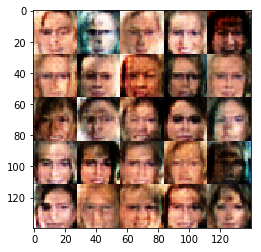

Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.4033...
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.4705...


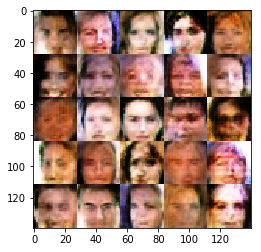

Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.5110...
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.5921...


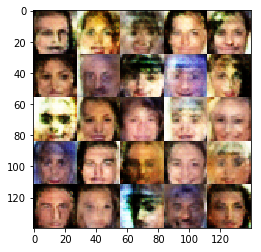

Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.4145...
Epoch 1/1... Discriminator Loss: 1.5867... Generator Loss: 0.3924...


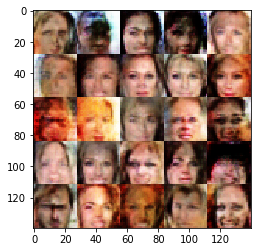

Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.8176...
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.5388...


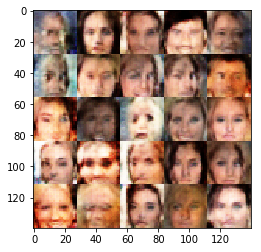

Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.5358...
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.4745...


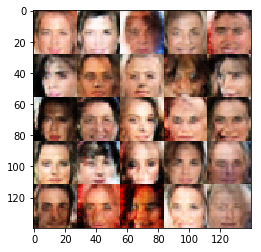

Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.8792...
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.4649...


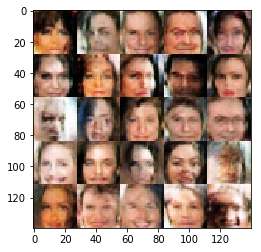

Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.4612...
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.4755...


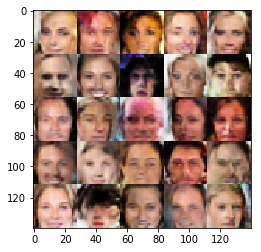

Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.3972...
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.5605...


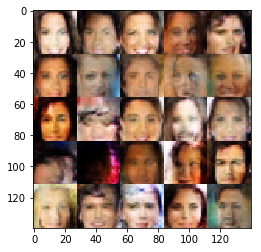

Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.5913...
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.4068...


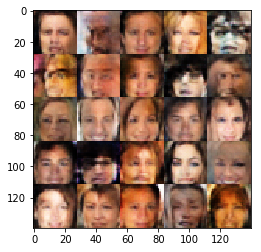

Epoch 1/1... Discriminator Loss: 1.5676... Generator Loss: 0.3874...


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。